**RUNNING PROJECT IN COMPLETELY DIFFERENT ENVIRONMENT**

**Installing ONNX - RUNTIME**

In [1]:
pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.7 MB/s eta 0:00:00


In [2]:
pip install torch

**IMPORTING ONNX AND RUNNING PROJECT**

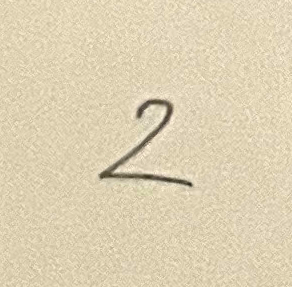

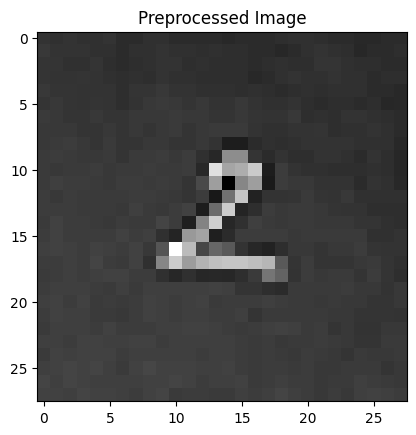

Predicted Digit :3


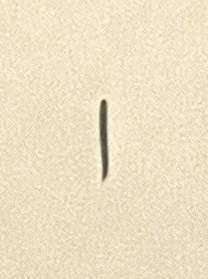

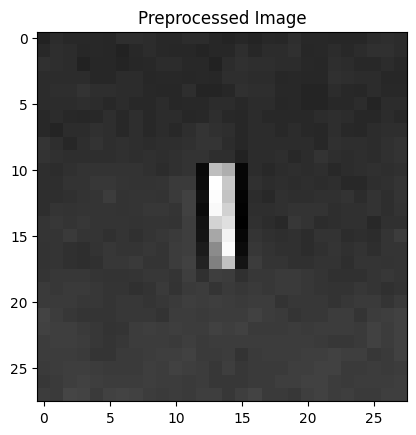

Predicted Digit :1


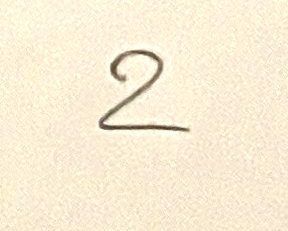

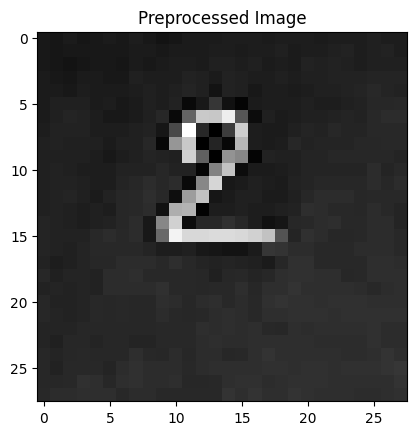

Predicted Digit :3


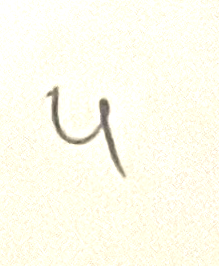

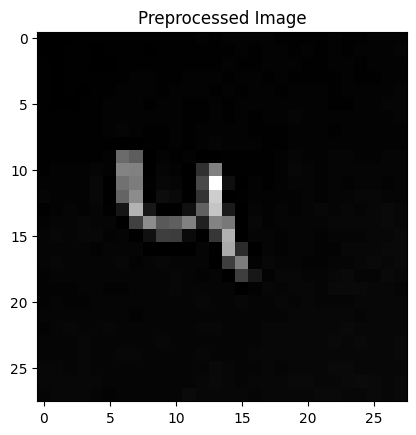

Predicted Digit :4


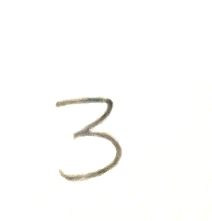

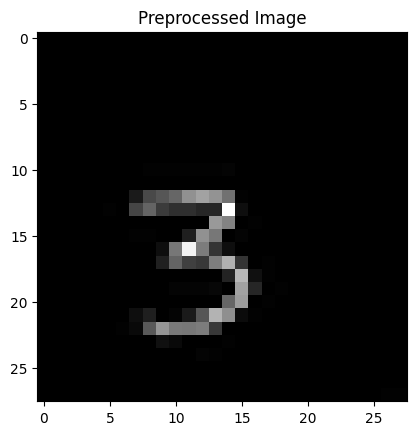

Predicted Digit :3
CORRECT ANSWERS [3, 4, 2, 1, 2]
PREDICTED ANSWERS [3, 4, 3, 1, 3]
Accuracy for sqp1.jpg: 60.0%


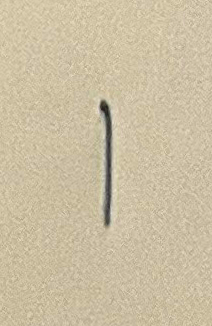

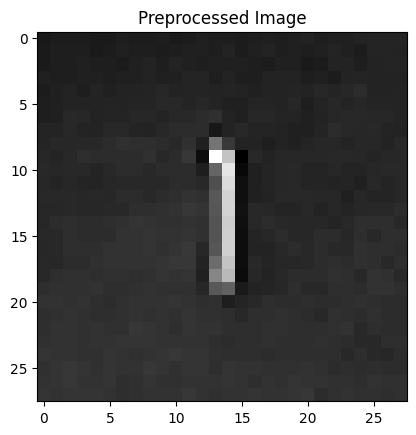

Predicted Digit :3


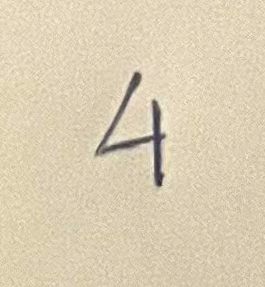

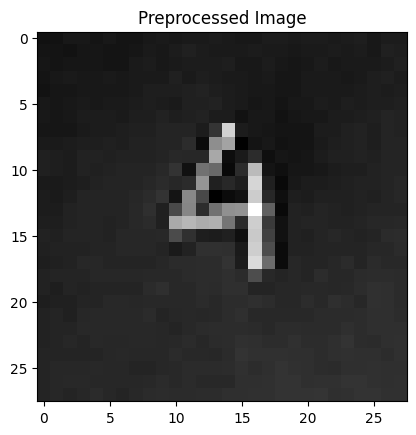

Predicted Digit :3


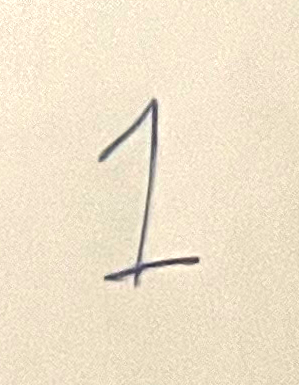

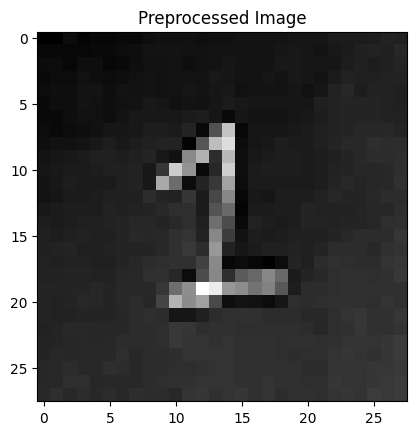

Predicted Digit :3


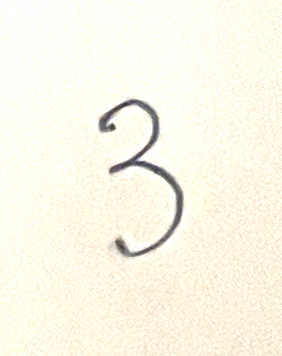

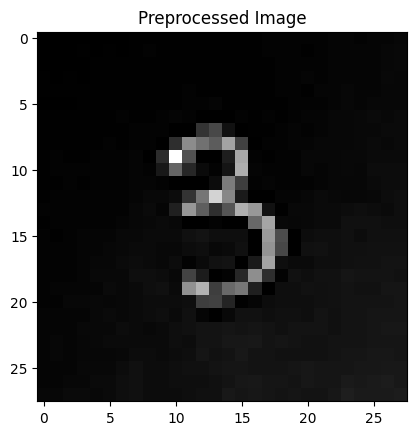

Predicted Digit :3


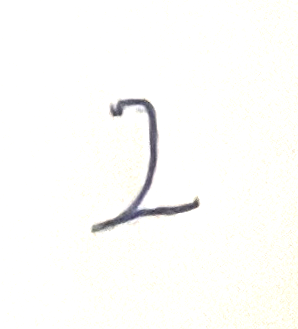

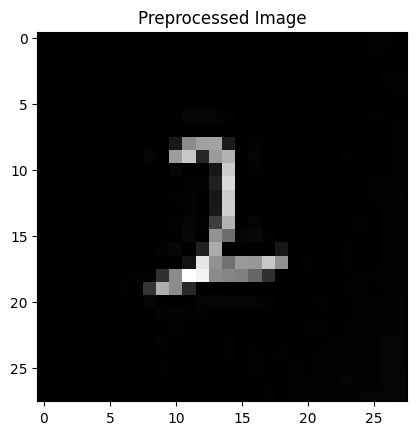

Predicted Digit :2
CORRECT ANSWERS [2, 3, 1, 4, 1]
PREDICTED ANSWERS [2, 3, 3, 3, 3]
Accuracy for sqp2.jpg: 40.0%


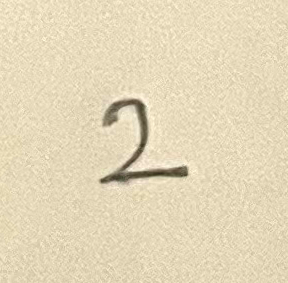

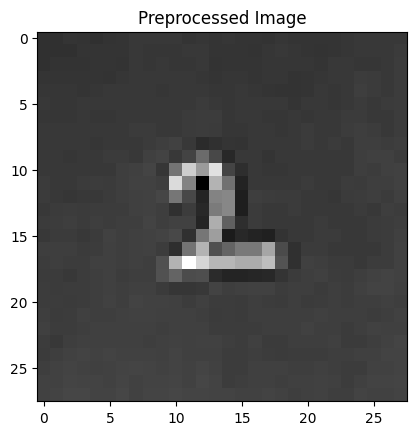

Predicted Digit :2


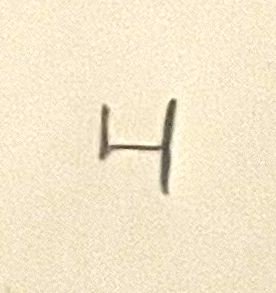

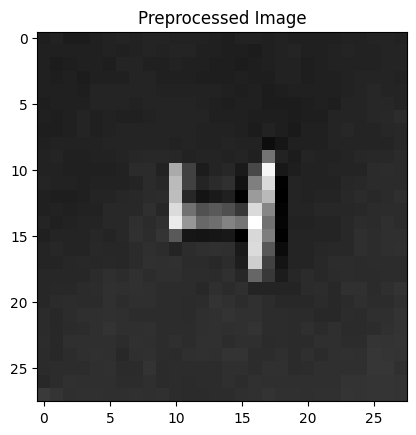

Predicted Digit :4


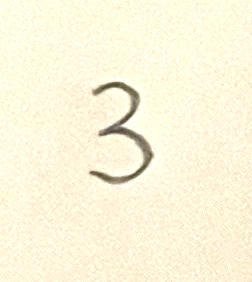

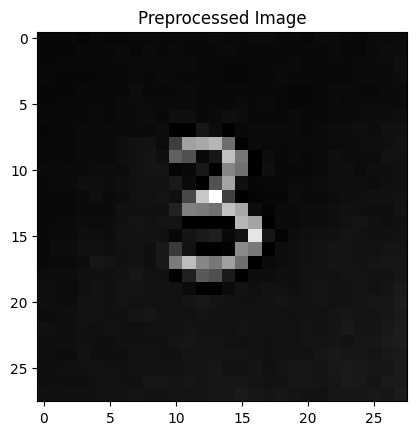

Predicted Digit :3


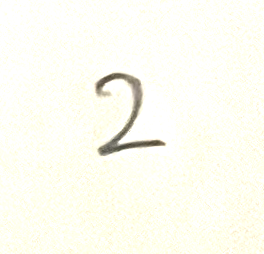

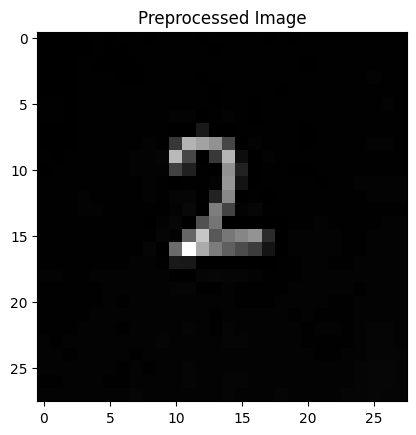

Predicted Digit :2


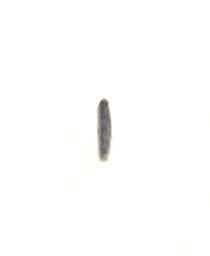

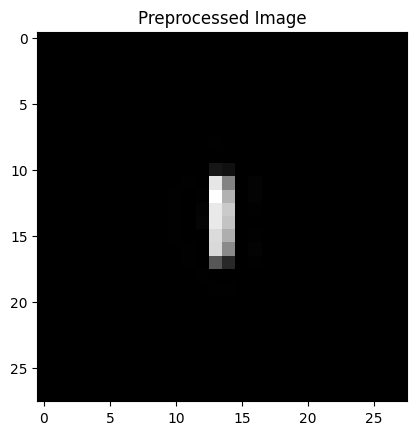

Predicted Digit :1
CORRECT ANSWERS [1, 2, 3, 4, 2]
PREDICTED ANSWERS [1, 2, 3, 4, 2]
Accuracy for sqp3.jpg: 100.0%


In [17]:
import onnxruntime as ort
from PIL import ImageOps
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from PIL import ImageOps
import numpy as np


# Load the ONNX model
session = ort.InferenceSession("mnist_model_1_to_4.onnx")
# Now you can use the session to get the input name and run the model
input_name = session.get_inputs()[0].name

def preprocess_image(image):
    # Convert to grayscale
    image = image.convert('L')

    # Invert colors in case the image is white on black
    image = ImageOps.invert(image)

    image = image.resize((28, 28), Image.Resampling.LANCZOS)

    # Convert to numpy array
    image_np = np.array(image)

    # Normalize the image
    image_np = (image_np - 0.1307) / 0.3081

    # Convert to numpy array and add batch dimension
    image_np = np.expand_dims(image_np, axis=0)  # Add batch dimension
    image_np = np.expand_dims(image_np, axis=0)  # Add channel dimension if needed

    return image_np

def predict_digit(image):
    # Check if the image needs to be opened
    if not isinstance(image, Image.Image):
        image = Image.open(image)

    # Preprocess the image
    image_np = preprocess_image(image)

    # Display the preprocessed image
    # Reshape the image for display: remove the first two dimensions
    display_image = image_np.squeeze()  # This will change shape from (1, 1, 28, 28) to (28, 28)
    plt.imshow(display_image, cmap='gray')
    plt.title("Preprocessed Image")
    plt.show()

    # Predict the class using the model
    with torch.no_grad():
        outputs = session.run(None, {input_name: image_np.astype(np.float32)})
    predicted_class = np.argmax(outputs[0]) + 1  # Adding 1 to match your label scheme

    return predicted_class



# Correct answers for each image
correct_answers = {
    'sqp1.jpg': [3, 4, 2, 1, 2],
    'sqp2.jpg': [2, 3, 1, 4, 1],
    'sqp3.jpg': [1, 2, 3, 4, 2]
}

# Process each image and compare with correct answers
for image_name in correct_answers.keys():
    # Load the image
    image_path = f'/content/{image_name}'
    image = cv2.imread(image_path)

    # Adjust contrast and brightness to enhance shadows and blacks
    alpha = 2.2  # Contrast control (1.0-3.0) previously 0.8
    beta = 30    # Brightness control (0-100) previously 79

    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    # Convert to grayscale
    gray = cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2GRAY)

    # Apply threshold or edge detection
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Minimum width threshold for boxes
    min_width = 140  # adjust this value as needed

    # Padding around the digit
    padding = 100  # adjust this value as needed

    papers=[]
    # Collect predictions for the current image
    predicted_digits = []
    for cnt in contours:
        # ... (your contour processing and digit recognition code)
        # Approximate the contour to a polygon
        epsilon = 0.05 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)

        # Check if the polygon has 4 sides (potential box)
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(cnt)

            # Crop and show the box only if the width is greater than min_width
            if w > min_width and w < 1000:
                # Crop the region of interest
                roi = adjusted_image[(y+10):y+(h-10), (x+10):x+(w-10)]
                # Convert the ROI to grayscale and threshold it
                roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
                _, roi_thresh = cv2.threshold(roi_gray, 127, 255, cv2.THRESH_BINARY_INV)

                # Find contours within the ROI
                roi_contours, _ = cv2.findContours(roi_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # Assuming the largest contour in the ROI is the digit
                if roi_contours:
                    digit_cnt = max(roi_contours, key=cv2.contourArea)
                    x_digit, y_digit, w_digit, h_digit = cv2.boundingRect(digit_cnt)

                    # Add padding around the digit
                    x_digit_padded = max(x_digit - padding, 0)
                    y_digit_padded = max(y_digit - padding, 0)
                    w_digit_padded = min(w_digit + 2 * padding, roi.shape[1])
                    h_digit_padded = min(h_digit + 2 * padding, roi.shape[0])

                    # Crop around the digit contour with padding
                    digit_roi = roi[y_digit_padded:y_digit_padded+h_digit_padded, x_digit_padded:x_digit_padded+w_digit_padded]
                    cv2_imshow(digit_roi)

                    # Convert cropped digit ROI to PIL Image
                    digit_roi_pil = Image.fromarray(cv2.cvtColor(digit_roi, cv2.COLOR_BGR2RGB))

                    digit = predict_digit(digit_roi_pil)
                    print("Predicted Digit :"+str(digit))
                    predicted_digits.append(digit)

    # Calculate accuracy
    correct_digits = correct_answers[image_name]
    predicted_digits=predicted_digits[::-1]
    print("CORRECT ANSWERS "+str(correct_digits))
    print("PREDICTED ANSWERS "+str(predicted_digits))
    total_digits = len(correct_digits)
    correct_predictions = sum(p == c for p, c in zip(predicted_digits, correct_digits))
    accuracy = correct_predictions / total_digits
    print(f"Accuracy for {image_name}: {accuracy * 100}%")

